In [ ]:
import glob
import json
import os
import sys
from typing import Any

from adjustText import adjust_text
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns


# ローカルモジュールの読み込み設定
sys.path.append(os.path.abspath("src"))
from core.config import TARGET_CITIES
from core.definitions import EDGE_DEFINITIONS, EdgeType, NodeType
from runner import AnalysisRunner

# フォント設定
JP_FONT = "IPAexGothic"
sns.set_theme(font=JP_FONT)
plt.rcParams["font.family"] = JP_FONT

# グラフJSONファイルの場所
JSON_DIR = "../output/graphs"


In [ ]:
print("Target cities:")
for city in TARGET_CITIES:
    print(f"- {city['name']} ({city['id']})")

Target cities:
- 札幌市 (01100)
- 仙台市 (04100)
- 文京区 (13105)
- 世田谷区 (13112)
- 港区 (13103)
- 渋谷区 (13113)
- 足立区 (13121)
- 名古屋市 (23100)
- 大阪市 (27100)
- 広島市 (34100)
- 福岡市 (40130)


In [52]:
runner = AnalysisRunner(procedure_name="児童手当 認定請求", output_dir=JSON_DIR)

# 全ての対象都市で分析を実行
results = runner.run_for_all_targets()

# 失敗した都市を特定
failed_cities = [city_id for city_id, result_path in results.items() if result_path is None]

if failed_cities:
    print(f"Analysis completed with failures for the following cities: {', '.join(failed_cities)}")
else:
    print("All analyses completed successfully.")

Starting analysis for 札幌市 (01100) - 児童手当 認定請求...
File ../output/graphs/01100_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 仙台市 (04100) - 児童手当 認定請求...
File ../output/graphs/04100_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 文京区 (13105) - 児童手当 認定請求...
File ../output/graphs/13105_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 世田谷区 (13112) - 児童手当 認定請求...
File ../output/graphs/13112_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 港区 (13103) - 児童手当 認定請求...
File ../output/graphs/13103_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 渋谷区 (13113) - 児童手当 認定請求...
File ../output/graphs/13113_児童手当 認定請求.json already exists. Skipping.
-------------------------------------

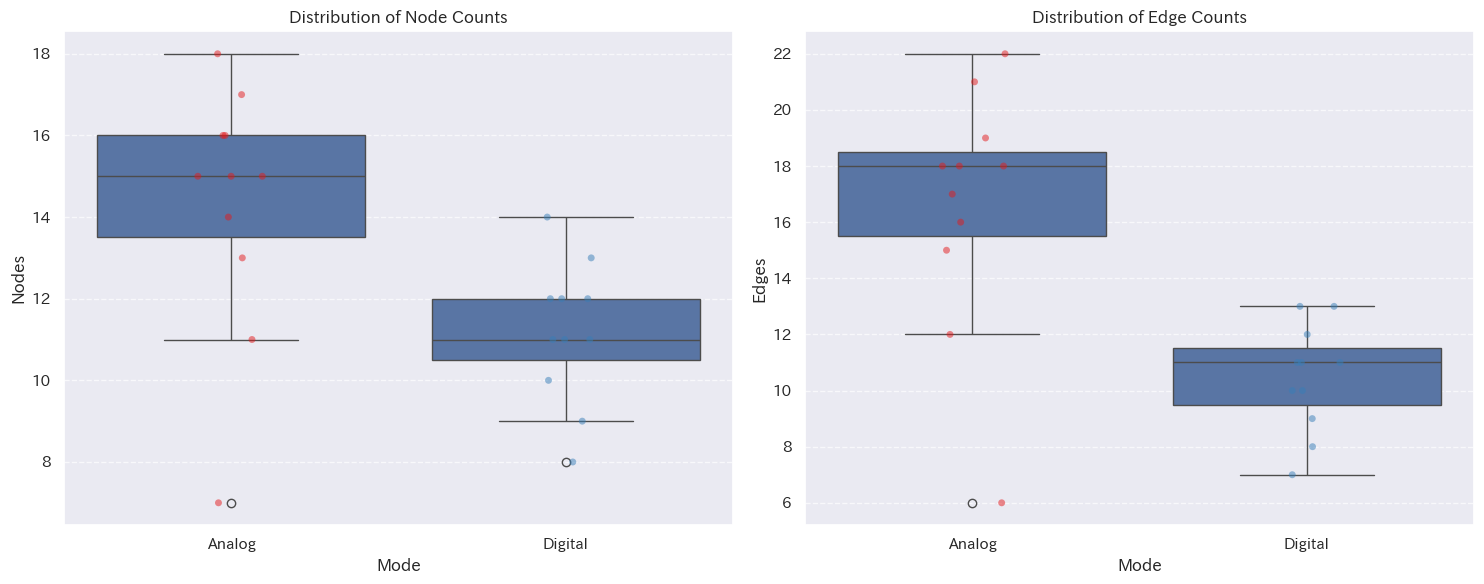

3 [-0.39120213  0.28301843]
17 [ 0.90673155 -0.75372938]
11 [-0.81324169 -0.39297743]
21 [-0.228812   -0.30532732]


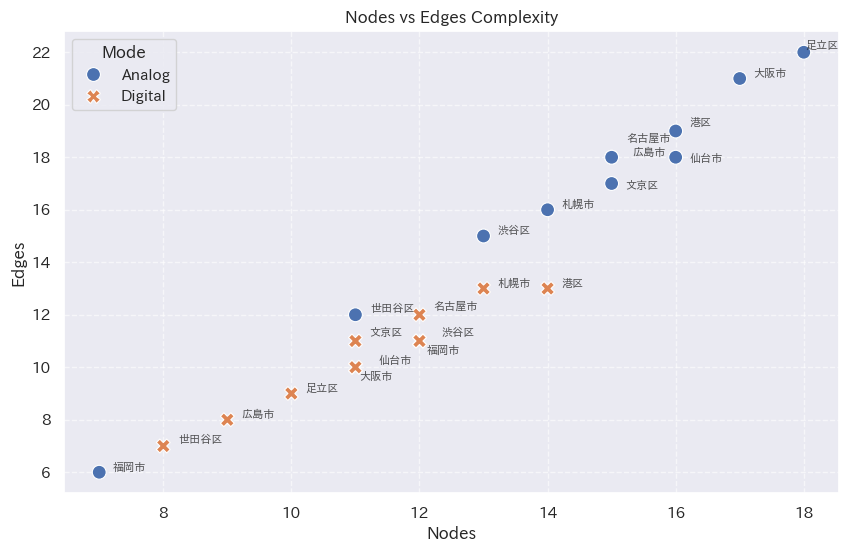

In [ ]:
# データ読み込み
records = []
json_data = {}

for city in TARGET_CITIES:
    file_pattern = os.path.join(JSON_DIR, f"{city['id']}_*.json")
    files = glob.glob(file_pattern)

    target_file = files[0]
    try:
        with open(target_file, encoding="utf-8") as f:
            data = json.load(f)
            json_data[city["id"]] = data

        # アナログデータの抽出
        a_nodes = len(data.get("analog_nodes", []))
        a_edges = len(data.get("analog_edges", []))
        records.append({"City": city["name"], "Mode": "Analog", "Nodes": a_nodes, "Edges": a_edges})

        # デジタルデータの抽出
        d_nodes = len(data.get("digital_nodes", []))
        d_edges = len(data.get("digital_edges", []))
        records.append({"City": city["name"], "Mode": "Digital", "Nodes": d_nodes, "Edges": d_edges})

    except Exception as e:
        print(f"Error processing {city['name']}: {e}")

# DataFrame作成
df = pd.DataFrame(records)

# 基本統計量の表示
stats = df.groupby("Mode")[["Nodes", "Edges"]].describe().T

# 外れ値検出のための可視化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ノード数の箱ひげ図
sns.boxplot(
    data=df,
    x="Mode",
    y="Nodes",
    ax=axes[0],
)
sns.stripplot(data=df, x="Mode", y="Nodes", color="black", alpha=0.5, ax=axes[0], hue="Mode", palette="Set1")
axes[0].set_title("Distribution of Node Counts")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# エッジ数の箱ひげ図
sns.boxplot(
    data=df,
    x="Mode",
    y="Edges",
    ax=axes[1],
)
sns.stripplot(data=df, x="Mode", y="Edges", color="black", alpha=0.5, ax=axes[1], hue="Mode", palette="Set1")
axes[1].set_title("Distribution of Edge Counts")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# 散布図による全体像の確認 (ノード数 vs エッジ数)
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="Nodes",
    y="Edges",
    hue="Mode",
    style="Mode",
    s=100,
)

# 各点に自治体名をラベル付け
texts = []
for _, row in df.iterrows():
    texts.append(plt.text(row["Nodes"] + 0.2, row["Edges"], row["City"], fontsize=8, alpha=0.8))
adjust_text(texts)

plt.title("Nodes vs Edges Complexity")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# # 具体的な外れ値候補のリストアップ (IQR法による簡易検出)
# def detect_outliers(group, col):
#     Q1 = group[col].quantile(0.25)
#     Q3 = group[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     return group[(group[col] < lower) | (group[col] > upper)]


# print("\n=== Potential Outliers (IQR Method) ===")
# for mode in ["Analog", "Digital"]:
#     subset = df[df["Mode"] == mode]
#     for col in ["Nodes", "Edges"]:
#         outliers = detect_outliers(subset, col)
#         if not outliers.empty:
#             print(f"[{mode} - {col}]")
#             print(outliers[["City", col]])
#             print("-" * 30)

Visualizing: 13105_児童手当 認定請求.json


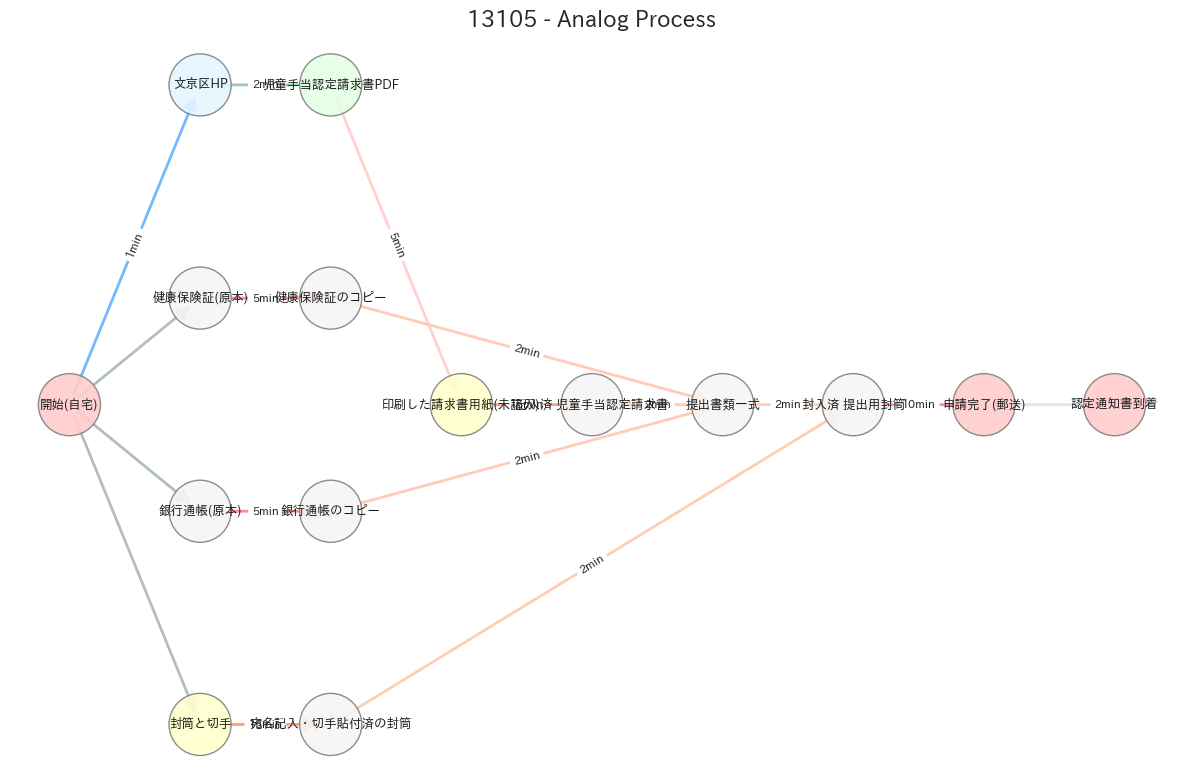

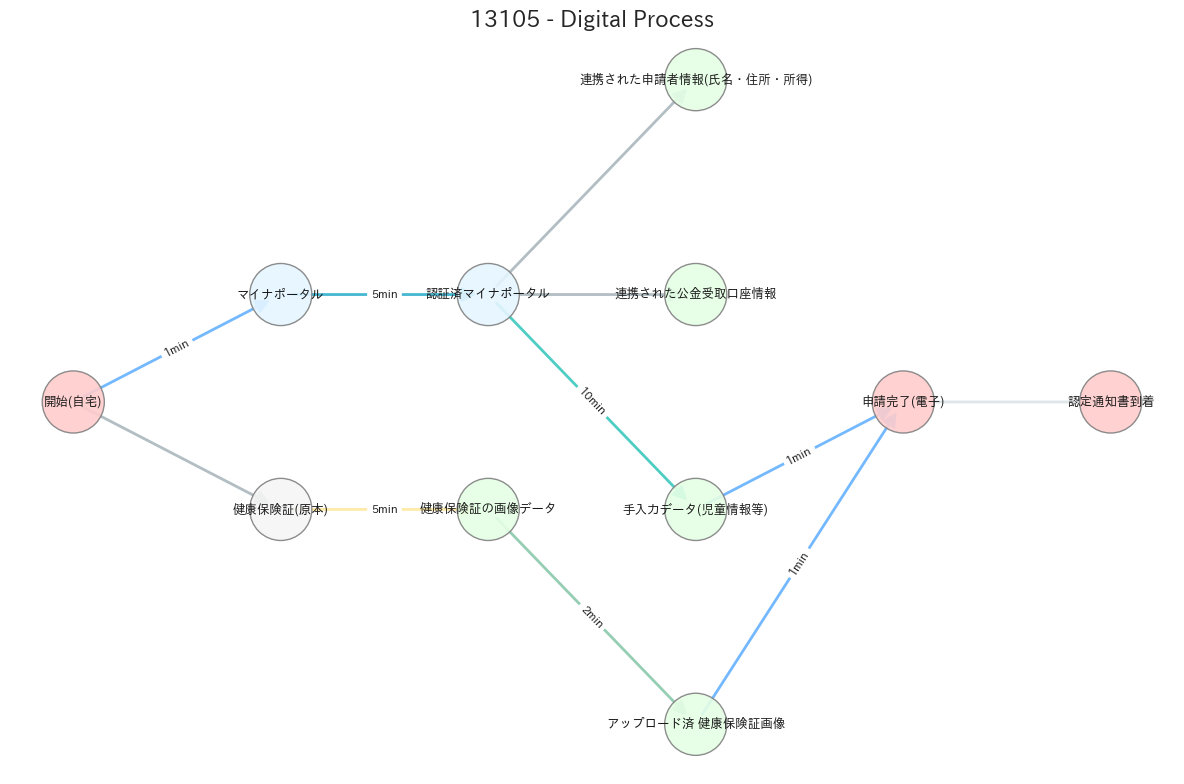

In [ ]:
EDGE_STYLES = {edge_enum: meta["meta"] for edge_enum, meta in EDGE_DEFINITIONS.items()}

# ノードの色定義
NODE_COLORS = {
    NodeType.Process_State: "#FFCCCC",  # 赤系 (State)
    NodeType.Digital_System: "#E5F5FF",  # 青系 (System)
    NodeType.Digital_Data_Object: "#E5FFE5",  # 緑系 (Data)
    NodeType.Physical_Raw_Material: "#FFFFCC",  # 黄系 (Raw)
    NodeType.Physical_Processed_Artifact: "#F5F5F5",  # グレー系 (Artifact)
}


def get_hierarchical_layout(G: nx.DiGraph):
    # トポロジカルソート
    pos = {}
    generations = list(nx.topological_generations(G))
    for x, layer_nodes in enumerate(generations):
        layer_size = len(layer_nodes)
        for y, node in enumerate(layer_nodes):
            y_pos = y - (layer_size - 1) / 2
            pos[node] = (x * 1.5, -y_pos)  # yにマイナスをつけると上から順になることが多い
    return pos


def create_networkx_graph(nodes: list[dict], edges: list[dict]) -> nx.DiGraph:
    """ノードとエッジリストからNetworkXの有向グラフを作成"""
    G = nx.DiGraph()

    # ノードを追加
    for node in nodes:
        G.add_node(node["id"], label=node["label"], type=node["type"])

    # エッジを追加
    for edge in edges:
        try:
            etype = EdgeType(edge["type"])
            meta = EDGE_STYLES.get(etype, {"base_cost": 0, "color": "black", "style": "solid"})
        except ValueError:
            meta = {"base_cost": 0, "color": "black", "style": "solid"}

        G.add_edge(
            edge["source_id"],
            edge["target_id"],
            type=edge["type"],
            cost=meta["base_cost"],
            color=meta.get("color", "black"),
            style=meta.get("style", "solid"),
        )
    return G


def visualize_graph(G: nx.DiGraph, title: str):
    """グラフを可視化して表示"""
    plt.figure(figsize=(12, 8))

    # レイアウト計算
    pos = get_hierarchical_layout(G)

    # ノード色の決定
    node_colors = []
    for node in G.nodes():
        node_type_str = G.nodes[node].get("type", "")
        color = "#FFFFFF"
        for ntype, c in NODE_COLORS.items():
            if ntype.value == node_type_str:
                color = c
                break
        node_colors.append(color)

    # 描画
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, edgecolors="gray", alpha=0.9)

    edges = G.edges(data=True)
    for u, v, data in edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            edge_color=data.get("color", "black"),
            style=data.get("style", "solid"),
            arrows=True,
            arrowsize=20,
            width=2,
        )

    labels = {node: G.nodes[node].get("label", node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family=JP_FONT)

    edge_labels = {(u, v): f"{d.get('cost')}min" for u, v, d in edges if d.get("cost", 0) > 0}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_family=JP_FONT)

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# ファイル検索
json_files = glob.glob(os.path.join(JSON_DIR, "*.json"))

# 最初のファイルだけ可視化する例 (全件ループも可能)
target_file = json_files[0]
filename = os.path.basename(target_file)
city_id = filename.split("_")[0]

print(f"Visualizing: {filename}")

data = json_data[city_id]

# アナロググラフ
if "analog_nodes" in data:
    G_analog = create_networkx_graph(data["analog_nodes"], data["analog_edges"])
    visualize_graph(G_analog, f"{city_id} - Analog Process")

# デジタルグラフ
if "digital_nodes" in data:
    G_digital = create_networkx_graph(data["digital_nodes"], data["digital_edges"])
    visualize_graph(G_digital, f"{city_id} - Digital Process")

In [ ]:
# 分析1: 構造的「深さ」と「手数」の比較

# データの読み込みと指標計算
records = []
base_dir = "./src/outputs/graphs"


def calculate_depth(nodes, edges):
    """DAGの最長パス（深さ）を計算"""
    G = nx.DiGraph()
    for n in nodes:
        G.add_node(n["id"])
    for e in edges:
        G.add_edge(e["source_id"], e["target_id"])

    try:
        # 閉路がある場合は計算不可（エラー値 -1）
        return nx.dag_longest_path_length(G)
    except nx.NetworkXUnfeasible:
        return -1


for json_file in glob.glob(os.path.join(base_dir, "*.json")):
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            # スキーマ揺らぎ吸収
            res = data.get("analysis_result", data.get("final_graph", data))

            filename = os.path.basename(json_file)
            city_name = filename.split("_")[0]  # 簡易的な自治体名抽出

            # Analog
            a_nodes = res.get("analog_nodes", [])
            a_edges = res.get("analog_edges", [])
            if a_nodes:
                records.append(
                    {"City": city_name, "Mode": "Analog", "Depth": calculate_depth(a_nodes, a_edges), "Volume": len(a_nodes)}
                )

            # Digital
            d_nodes = res.get("digital_nodes", [])
            d_edges = res.get("digital_edges", [])
            if d_nodes:
                records.append(
                    {"City": city_name, "Mode": "Digital", "Depth": calculate_depth(d_nodes, d_edges), "Volume": len(d_nodes)}
                )

    except Exception as e:
        print(f"Error: {e}")

df_depth = pd.DataFrame(records)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 深さ（最長パス）の比較
sns.boxplot(data=df_depth, x="Mode", y="Depth", ax=axes[0], palette="Pastel1", showfliers=False)
sns.stripplot(data=df_depth, x="Mode", y="Depth", color="black", alpha=0.6, ax=axes[0])
axes[0].set_title("Dependency Depth (Longest Path Length)")
axes[0].set_ylabel("Steps")

# 2. 手数（ノード数）の比較
sns.boxplot(data=df_depth, x="Mode", y="Volume", ax=axes[1], palette="Pastel1", showfliers=False)
sns.stripplot(data=df_depth, x="Mode", y="Volume", color="black", alpha=0.6, ax=axes[1])
axes[1].set_title("Process Volume (Total Node Count)")
axes[1].set_ylabel("Count")

plt.suptitle("Structural Complexity Analysis: Analog vs Digital", fontsize=16)
plt.tight_layout()
plt.show()

# 統計量の表示
print(df_depth.groupby("Mode")[["Depth", "Volume"]].describe().T)